In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "13b"
target_lang = "ru"
input_lang = "zh"
type = "logit"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"../tuned-lens/my_lenses/chinese/{model_size}").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"../tuned-lens/my_lenses/chinese/{model_size}").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=5120, out_features=32000, bias=False)
)
U torch.Size([32000, 5120]) weights torch.Size([1, 5120])


0.11461826413869858


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for ru 15 of 115 are single tokens
final length of df_en_ru_zh: 115


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                               | 0/115 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                     | 1/115 [00:00<00:23,  4.78it/s]

  2%|███▍                                                                                                                                                                                                   | 2/115 [00:00<00:26,  4.32it/s]

  3%|█████▏                                                                                                                                                                                                 | 3/115 [00:00<00:23,  4.74it/s]

  3%|██████▉                                                                                                                                                                                                | 4/115 [00:00<00:22,  4.97it/s]

  4%|████████▋                                                                                                                                                                                              | 5/115 [00:01<00:22,  4.96it/s]

  5%|██████████▍                                                                                                                                                                                            | 6/115 [00:01<00:24,  4.50it/s]

  6%|████████████                                                                                                                                                                                           | 7/115 [00:01<00:24,  4.37it/s]

  7%|█████████████▊                                                                                                                                                                                         | 8/115 [00:01<00:23,  4.53it/s]

  8%|███████████████▌                                                                                                                                                                                       | 9/115 [00:01<00:23,  4.55it/s]

  9%|█████████████████▏                                                                                                                                                                                    | 10/115 [00:02<00:24,  4.29it/s]

 10%|██████████████████▉                                                                                                                                                                                   | 11/115 [00:02<00:22,  4.53it/s]

 10%|████████████████████▋                                                                                                                                                                                 | 12/115 [00:02<00:25,  4.03it/s]

 11%|██████████████████████▍                                                                                                                                                                               | 13/115 [00:02<00:24,  4.17it/s]

 12%|████████████████████████                                                                                                                                                                              | 14/115 [00:03<00:22,  4.44it/s]

 13%|█████████████████████████▊                                                                                                                                                                            | 15/115 [00:03<00:21,  4.66it/s]

 14%|███████████████████████████▌                                                                                                                                                                          | 16/115 [00:03<00:21,  4.58it/s]

 15%|█████████████████████████████▎                                                                                                                                                                        | 17/115 [00:03<00:21,  4.67it/s]

 16%|██████████████████████████████▉                                                                                                                                                                       | 18/115 [00:03<00:19,  4.86it/s]

 17%|████████████████████████████████▋                                                                                                                                                                     | 19/115 [00:04<00:19,  4.87it/s]

 17%|██████████████████████████████████▍                                                                                                                                                                   | 20/115 [00:04<00:19,  4.82it/s]

 18%|████████████████████████████████████▏                                                                                                                                                                 | 21/115 [00:04<00:18,  5.03it/s]

 19%|█████████████████████████████████████▉                                                                                                                                                                | 22/115 [00:04<00:18,  5.08it/s]

 20%|███████████████████████████████████████▌                                                                                                                                                              | 23/115 [00:04<00:18,  5.03it/s]

 21%|█████████████████████████████████████████▎                                                                                                                                                            | 24/115 [00:05<00:18,  5.00it/s]

 22%|███████████████████████████████████████████                                                                                                                                                           | 25/115 [00:05<00:17,  5.20it/s]

 23%|████████████████████████████████████████████▊                                                                                                                                                         | 26/115 [00:05<00:17,  5.06it/s]

 23%|██████████████████████████████████████████████▍                                                                                                                                                       | 27/115 [00:05<00:19,  4.59it/s]

 24%|████████████████████████████████████████████████▏                                                                                                                                                     | 28/115 [00:06<00:18,  4.61it/s]

 25%|█████████████████████████████████████████████████▉                                                                                                                                                    | 29/115 [00:06<00:18,  4.66it/s]

 26%|███████████████████████████████████████████████████▋                                                                                                                                                  | 30/115 [00:06<00:19,  4.27it/s]

 27%|█████████████████████████████████████████████████████▎                                                                                                                                                | 31/115 [00:06<00:18,  4.58it/s]

 28%|███████████████████████████████████████████████████████                                                                                                                                               | 32/115 [00:06<00:19,  4.19it/s]

 29%|████████████████████████████████████████████████████████▊                                                                                                                                             | 33/115 [00:07<00:18,  4.48it/s]

 30%|██████████████████████████████████████████████████████████▌                                                                                                                                           | 34/115 [00:07<00:17,  4.59it/s]

 30%|████████████████████████████████████████████████████████████▎                                                                                                                                         | 35/115 [00:07<00:17,  4.66it/s]

 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                        | 36/115 [00:07<00:16,  4.91it/s]

 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                      | 37/115 [00:07<00:16,  4.62it/s]

 33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                    | 38/115 [00:08<00:15,  5.07it/s]

 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                  | 39/115 [00:08<00:15,  5.06it/s]

 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 40/115 [00:08<00:15,  4.96it/s]

 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                               | 41/115 [00:08<00:14,  5.09it/s]

 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 42/115 [00:08<00:13,  5.40it/s]

 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                            | 43/115 [00:09<00:14,  5.08it/s]

 38%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 44/115 [00:09<00:12,  5.49it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 45/115 [00:09<00:12,  5.40it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 46/115 [00:09<00:13,  5.13it/s]

 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 47/115 [00:09<00:13,  5.02it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 48/115 [00:10<00:12,  5.16it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 49/115 [00:10<00:12,  5.17it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 50/115 [00:10<00:13,  4.95it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 51/115 [00:10<00:12,  4.94it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 52/115 [00:10<00:12,  4.97it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 53/115 [00:11<00:12,  4.85it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 54/115 [00:11<00:12,  4.73it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 55/115 [00:11<00:13,  4.39it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 56/115 [00:11<00:13,  4.36it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 57/115 [00:12<00:13,  4.36it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 58/115 [00:12<00:12,  4.43it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 59/115 [00:12<00:12,  4.45it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 60/115 [00:12<00:12,  4.53it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 61/115 [00:12<00:11,  4.63it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 62/115 [00:13<00:11,  4.62it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 63/115 [00:13<00:11,  4.34it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 64/115 [00:13<00:11,  4.41it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 65/115 [00:13<00:11,  4.23it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 66/115 [00:14<00:12,  3.84it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 67/115 [00:14<00:13,  3.53it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 68/115 [00:14<00:12,  3.67it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 69/115 [00:15<00:12,  3.60it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 70/115 [00:15<00:11,  3.86it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 71/115 [00:15<00:10,  4.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 72/115 [00:15<00:09,  4.43it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 73/115 [00:15<00:09,  4.52it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 74/115 [00:16<00:09,  4.42it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 75/115 [00:16<00:10,  3.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 76/115 [00:16<00:09,  4.00it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77/115 [00:16<00:09,  3.92it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 78/115 [00:17<00:08,  4.28it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 79/115 [00:17<00:08,  4.36it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 80/115 [00:17<00:08,  4.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 81/115 [00:17<00:08,  4.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 82/115 [00:18<00:08,  4.07it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 83/115 [00:18<00:08,  3.96it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 84/115 [00:18<00:07,  4.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 85/115 [00:18<00:08,  3.73it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 86/115 [00:19<00:07,  4.04it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 87/115 [00:19<00:06,  4.33it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 88/115 [00:19<00:06,  4.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 89/115 [00:19<00:06,  3.74it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 90/115 [00:20<00:06,  3.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 91/115 [00:20<00:06,  3.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 92/115 [00:20<00:06,  3.49it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 93/115 [00:20<00:05,  4.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 94/115 [00:21<00:05,  3.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 95/115 [00:21<00:04,  4.00it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 96/115 [00:21<00:04,  4.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 97/115 [00:21<00:04,  4.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 98/115 [00:22<00:04,  3.90it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 99/115 [00:22<00:04,  3.97it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 100/115 [00:22<00:03,  3.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 101/115 [00:23<00:03,  3.68it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 102/115 [00:23<00:03,  4.10it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 103/115 [00:23<00:02,  4.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 104/115 [00:23<00:02,  4.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 105/115 [00:23<00:02,  4.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 106/115 [00:24<00:02,  4.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 107/115 [00:24<00:01,  4.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 108/115 [00:24<00:01,  4.39it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 109/115 [00:24<00:01,  4.34it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 110/115 [00:25<00:01,  4.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 111/115 [00:25<00:00,  4.09it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 112/115 [00:25<00:00,  4.27it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 113/115 [00:25<00:00,  4.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 114/115 [00:25<00:00,  4.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:26<00:00,  4.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:26<00:00,  4.39it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df["prompt"][0]

'中文: "群" - Русский: "группа"\n中文: "山" - Русский: "гора"\n中文: "雪" - Русский: "снег"\n中文: "色" - Русский: "цвет"\n中文: "书" - Русский: "'

In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    hd= []
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
        hd+=[lens.transform_hidden(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hd)
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:01,  1.51s/it]

2it [00:01,  1.27it/s]

3it [00:02,  1.82it/s]

4it [00:02,  2.27it/s]

5it [00:02,  2.65it/s]

6it [00:02,  2.99it/s]

7it [00:03,  3.20it/s]

8it [00:03,  3.37it/s]

9it [00:03,  3.35it/s]

10it [00:03,  3.47it/s]

11it [00:04,  3.60it/s]

12it [00:04,  3.68it/s]

13it [00:04,  3.67it/s]

14it [00:04,  3.74it/s]

15it [00:05,  3.63it/s]

16it [00:05,  3.50it/s]

17it [00:05,  3.58it/s]

18it [00:06,  3.62it/s]

19it [00:06,  3.38it/s]

20it [00:06,  3.59it/s]

21it [00:06,  3.64it/s]

22it [00:07,  3.70it/s]

23it [00:07,  3.83it/s]

24it [00:07,  3.81it/s]

25it [00:07,  3.82it/s]

26it [00:08,  3.72it/s]

27it [00:08,  3.82it/s]

28it [00:08,  3.89it/s]

29it [00:08,  4.04it/s]

30it [00:09,  4.02it/s]

31it [00:09,  4.06it/s]

32it [00:09,  3.94it/s]

33it [00:09,  4.04it/s]

34it [00:10,  4.13it/s]

35it [00:10,  4.06it/s]

36it [00:10,  4.18it/s]

37it [00:10,  4.20it/s]

38it [00:11,  4.21it/s]

39it [00:11,  4.32it/s]

40it [00:11,  4.13it/s]

41it [00:11,  3.98it/s]

42it [00:12,  3.97it/s]

43it [00:12,  4.08it/s]

44it [00:12,  4.03it/s]

45it [00:12,  4.04it/s]

46it [00:13,  4.14it/s]

47it [00:13,  4.20it/s]

48it [00:13,  4.31it/s]

49it [00:13,  4.31it/s]

50it [00:14,  4.42it/s]

51it [00:14,  4.19it/s]

52it [00:14,  4.30it/s]

53it [00:14,  4.28it/s]

54it [00:14,  4.29it/s]

55it [00:15,  4.49it/s]

56it [00:15,  4.53it/s]

57it [00:15,  4.48it/s]

58it [00:15,  4.55it/s]

59it [00:16,  4.50it/s]

60it [00:16,  4.32it/s]

61it [00:16,  3.97it/s]

62it [00:16,  4.03it/s]

63it [00:17,  4.19it/s]

64it [00:17,  4.08it/s]

65it [00:17,  4.13it/s]

66it [00:17,  4.00it/s]

67it [00:18,  4.07it/s]

68it [00:18,  3.98it/s]

69it [00:18,  4.13it/s]

70it [00:18,  4.03it/s]

71it [00:19,  4.15it/s]

72it [00:19,  4.07it/s]

73it [00:19,  4.14it/s]

74it [00:19,  4.08it/s]

75it [00:20,  4.05it/s]

76it [00:20,  4.21it/s]

77it [00:20,  4.16it/s]

78it [00:20,  4.18it/s]

79it [00:20,  4.17it/s]

80it [00:21,  4.19it/s]

81it [00:21,  4.23it/s]

82it [00:21,  4.08it/s]

83it [00:21,  4.10it/s]

84it [00:22,  4.00it/s]

85it [00:22,  4.03it/s]

86it [00:22,  4.19it/s]

87it [00:22,  4.19it/s]

88it [00:23,  4.22it/s]

89it [00:23,  4.32it/s]

90it [00:23,  4.30it/s]

91it [00:23,  4.22it/s]

92it [00:24,  4.33it/s]

93it [00:24,  4.26it/s]

94it [00:24,  4.27it/s]

95it [00:24,  4.39it/s]

96it [00:25,  4.29it/s]

97it [00:25,  4.29it/s]

98it [00:25,  4.28it/s]

99it [00:25,  4.20it/s]

100it [00:25,  4.04it/s]

101it [00:26,  4.05it/s]

102it [00:26,  4.18it/s]

103it [00:26,  4.19it/s]

104it [00:26,  4.15it/s]

105it [00:27,  4.27it/s]

106it [00:27,  4.32it/s]

107it [00:27,  4.32it/s]

108it [00:27,  3.87it/s]

109it [00:28,  3.83it/s]

110it [00:28,  3.91it/s]

111it [00:28,  3.86it/s]

112it [00:28,  4.07it/s]

113it [00:29,  4.01it/s]

114it [00:29,  4.11it/s]

115it [00:29,  4.17it/s]

115it [00:29,  3.88it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


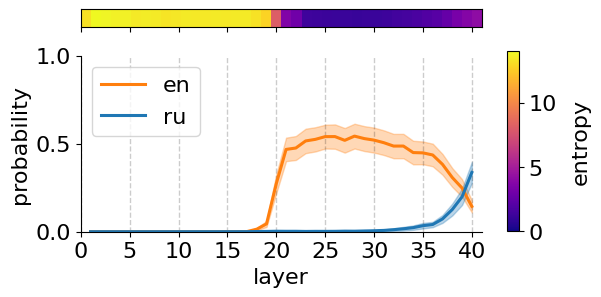

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

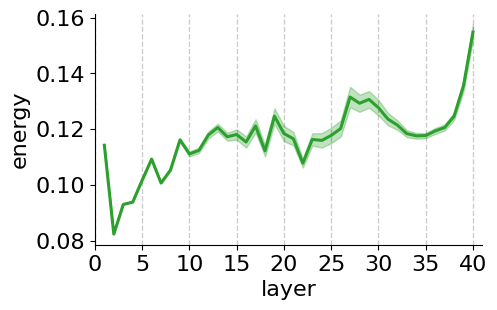

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')